# Вступление

Этот проект показывает: 
- способность писать структурированный код на Python. 
- возможность использования существующих утилит(библиотек) для обработки и анализа данных.
- применение исследовательского анализа
- навыки анализа и предварительной обработки данных
- визуализация данных

Проект включает в себя:
1. Предварительная обработка данных
2. Исследовательский анализ

Проект из учебного курса "[Специалист по Data Science](https://praktikum.yandex.ru/data-scientist)" от [Яндекс Практикум](https://practicum.yandex.ru/).

# Подготовка проекта

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
!pip install folium

# Импорт библиотек

In [3]:
import numpy as np
import pandas as pd
from scipy import stats as st
import warnings
# Для чтения файла
import os 
from pathlib import Path
import urllib
# Для визуализации графиков
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# карта
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# Настройка matplotlib

In [4]:
%matplotlib inline
small, medium, large = 14, 16, 22
params = {'figure.figsize':   (14, 5),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [5]:
# повышение четкости на больших экранах
%config InlineBackend.figure_format = 'retina'

In [6]:
# отключим всякие предупреждения Anaconda
warnings.filterwarnings('ignore')

In [7]:
# уберём экспоненциальную запись
pd.options.display.float_format = '{:.3f}'.format

In [8]:
# вывод всех столбцов
pd.set_option('display.max_columns', None)

# Извлечение данных

# Проект "Анализ авиарейсов"

## Описание проекта 

Авиакомпания нуждается в аналитике данных по авиарейсам. Необходимо понять предпочтения пользователей, покупающих билеты на разные направления.

## Детали задачи

- Найти топ-10 городов по количеству рейсов
- Проанализировать:
    - модели самолётов
    - города
    - количество рейсов

## Описание данных

В нашем распоряжении результаты SQL запросов:
1. Количество рейсов на каждой модели самолётов с вылетом в сентябре 2018 года. 
2. Среднее количество прибывающих рейсов в день для каждого города за август 2018 года.



### Первый запрос

 |Столбец            |Описание          |
 |:---------------|:------------------------|
 |model   | Модель самолёта
 |flights_amount   | Количество рейсов для каждой модели самолетов в сентябре 2018 года|

### Второй запрос

 |Столбец            |Описание          |
 |:---------------|:------------------------|
 |city   |Город |
 |average_flights  |Среднее количество рейсов, прибывающих в город за день в сентябре 2018 года|

## Цель проекта
Необходимо проанализировать данные по рейсам и помочь авиакомпании понять предпочтения пользователей.

## План работы
1. [Обзор данных](#review)
2. [Предобработка данных](#dataPreprocessing)
    - [Изменение типа данных](#changingDataTypes)
    - [Проверка данных](#dataCheck)
    - [Feature Engineering](#featureEngineering)
3. [Исследовательский анализ данных](#ExploratoryAnalysis)
    - [Анализ моделей самолётов](#modelAnalysis)
    - [Анализ городов](#cityAnalysis)
4. [Результаты работы](#results)

<a id="review"></a>
# Этап 1 - Обзор данных

Прочитаем предоставленные файлы. Сохраним в соотвествующие переменные.

In [9]:
Path('datasets').mkdir(parents=True, exist_ok=True)
#Создаем функцию для чтения файла
def get_file(file_name, url):
    # Проверяем есть ли файл
    if not os.path.exists(file_name):
        print(file_name,'файл не найден, будет загружен из сети')
        # качаем файл по ссылке url, кладем по пути file_name
        # загружаем с помощью библиотеки urllib
        _ = urllib.request.urlretrieve(url, file_name)
        
# Словарь с именем файла и ссылкой на него
urls = {
    'query_1': ('datasets/query_1.csv', '_________'),
    'query_2': ('datasets/query_3.csv', '__________'),
    'cities_info': ('datasets/cities_info.csv', 'https://gist.githubusercontent.com/dnovik/694d106be3ff20eb0c73a0511c83b7f3/raw/056b7ece3b762723c02d3809ef77e2ae92a2bcd0/cities.csv')
}
[get_file(*urls[k]) for k in urls]
[get_file(urls[k][0], urls[k][1]) for k in urls]

# сохраним полученный из файла датафрейм в соответствующую переменную
raw_query_1 = pd.read_csv(urls['query_1'][0],sep=',')
raw_query_2 = pd.read_csv(urls['query_2'][0],sep=',')
cities_info = pd.read_csv(urls['cities_info'][0],sep=',')

Посмотрим на данные. Выведем первые 10 строк таблицы.

In [10]:
raw_query_1.head(10)

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


Всего 8 наблюдений(строк) в данных по моделям самолетов.

In [11]:
raw_query_2.head(10)

,city,average_flights
0,Абакан,3.871
1,Анадырь,1.000
2,Анапа,2.161
3,Архангельск,5.355
4,Астрахань,2.452
5,Барнаул,2.613
6,Белгород,6.000
7,Белоярский,2.000
8,Благовещенск,1.000
9,Братск,1.000


Посмотрим на общие данные, вызвав метод *info()*

In [12]:
raw_query_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


В данных два признака: model с типом данных *object*, flights_amount с типом данных *int64*. Всего 8 наблюдений. Количество строк соответствует между двумя столбцами. Следовательно, нет пропущенных значений. 

In [13]:
raw_query_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


В данных также два признака: city с типом данных *object*, average_flights с типом данных *float64*. 101 наблюдений. Количество строк соответствует между двумя столбцами. Следовательно, нет пропущенных значений. Предлагаю в предобработке данных поменять тип данных столбца *average_flights* на тип данных *float16*

Выведем распределения в данных.

In [14]:
raw_query_1.describe().T

,count,mean,std,min,25%,50%,75%,max
flights_amount,8.000,2035.625,1965.204,300.000,605.250,795.000,4250.250,4557.000


В среднем количество рейсов для каждой модели самолетов - 2035. Минимальное значени - 300 рейсов, максимальное значение - 4557 рейсов. 

In [15]:
raw_query_2.describe().T

,count,mean,std,min,25%,50%,75%,max
average_flights,101.000,5.494,13.120,1.000,2.000,3.000,5.871,129.774


Среднее - 5 рейсов в день среди городов. Минимальное - 1 рейс, максимальное - 129 рейсов. Отрицательных значений не обнаружилось. 

## Вывод
Пропущенных значений не обнаружилось. Необходимо проверить данные на дупликаты. Отрицательных значений не обнаружилось. Аномальных значений не обнаружилось. Проблем со столбцами не обнаружилось.
<br><br>
Данные по первому запросу: 
- В данных два признака: model с типом данных *object*, flights_amount с типом данных *int64*.
- Всего 8 наблюдений.
- В среднем количество рейсов для каждой модели самолетов - 2035
- Минимальное значени - 300 рейсов
- Максимальное значение - 4557 рейсов


Данные по второму запросу: 
- В данных также два признака: city с типом данных *object*, average_flighs с типом данных *float64*. 
- 101 наблюдений.
- Среднее - 5 рейсов в день среди городов.
- Минимальное - 1 рейс.
- Максимальное - 129 рейсов.

Перейдём к предобработке данных.

<a id="dataPreprocessing"></a>
# Этап 2 - Предобработка данных

На этом этапе нам необходимо:
1. Изменить тип данных 
2. Проверка данных на дупликаты, отрицательные значения.

<a id="changingDataTypes"></a>
## Изменение типа данных

Заменим вещественный тип данных в столбце *average_flights*.

In [16]:
try:
    raw_query_2['average_flights'] = raw_query_2['average_flights'].astype('float16')
except:
    print('Проверьте есть ли пропущенные значения.')

<a id="dataCheck"></a>
## Проверка данных

Напишем функцию которая проверит:
1. Пропущенные значения
2. Дупликаты
4. Соответствующие типы данных int64, object

In [17]:
def get_preprocessed_data(raw_data):
    """
    Функция проверяет данные. Возвращает предобработанные данные для обучения.
    raw_data - данные для проверки
    """
    # проверяем данные
    assert raw_data.isna().sum().sum() == 0, 'В данных не должно быть пропущенных значений!'
    assert raw_data.select_dtypes(exclude=[np.int64, object, np.float16]).size == 0, 'Данные должны иметь только численный и строковый тип данных!'
    assert raw_data.duplicated().sum().sum() == 0, 'В данных не должно быть дупликатов!'
    print('Данные проверку прошли!')
    #создаем копию оригинального датафрейма
    preprocessed_data = raw_data.copy()
    
    return preprocessed_data

In [18]:
models = get_preprocessed_data(raw_query_1)

Данные проверку прошли!


In [19]:
city = get_preprocessed_data(raw_query_2)

Данные проверку прошли!


<a id="featureEngineering"></a>
## Feature Engineering

Извелечём из существующих признаков дополнительную информацию, которую мы преобразуем в новый признак.

### Models

In [20]:
models

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


Создадим признак *company*. Из строки столбца *model* извлечём первое слово, которая представляет из себя авиакомпанию, которая создала эту модель.

In [21]:
def companyExtraction(model):
    company = model.split()[0]
    return company

In [22]:
models['company'] = models['model'].apply(companyExtraction)

In [23]:
models

,model,flights_amount,company
0,Airbus A319-100,607,Airbus
1,Airbus A321-200,960,Airbus
2,Boeing 737-300,630,Boeing
3,Boeing 767-300,600,Boeing
4,Boeing 777-300,300,Boeing
5,Bombardier CRJ-200,4446,Bombardier
6,Cessna 208 Caravan,4557,Cessna
7,Sukhoi SuperJet-100,4185,Sukhoi


## City

Обратимся к интернету, и возьмем [открытый датасет по городам России от вебсайта DaData.ru](https://dadata.ru/opendata/).

Выведем первые 5 строк.

In [24]:
cities_info.head()

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,Код ФИАС,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
0,385200.000,Респ,Адыгея,NaN,NaN,г,Адыгейск,NaN,NaN,100000200000,ccdfd496-8108-4655-aadd-bd228747306d,4: город,0,79403000000,79703000001.000,107,UTC+3,44.878,39.190,Южный,12689
1,385000.000,Респ,Адыгея,NaN,NaN,г,Майкоп,NaN,NaN,100000100000,8cfbe842-e803-49ca-9347-1ef90481dd98,4: город,2,79401000000,79701000001.000,105,UTC+3,44.610,40.101,Южный,144055
2,649000.000,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,NaN,NaN,400000100000,0839d751-b940-4d3d-afb6-5df03fdd7791,4: город,2,84401000000,84701000.000,400,UTC+7,51.958,85.960,Сибирский,62861
3,658125.000,край,Алтайский,NaN,NaN,г,Алейск,NaN,NaN,2200000200000,ae716080-f27b-40b6-a555-cf8b518e849e,4: город,0,1403000000,1703000.000,2201,UTC+7,52.492,82.779,Сибирский,28528
4,656000.000,край,Алтайский,NaN,NaN,г,Барнаул,NaN,NaN,2200000100000,d13945a8-7017-46ab-b1e6-ede1e89317ad,4: город,2,1401000000,1701000.000,2200,UTC+7,53.348,83.780,Сибирский,635585


Возьмём следующие признаки: *регион, город, широта, долгота, федеральный округ*

In [25]:
cities_info = cities_info[['Регион','Город','Широта','Долгота','Федеральный округ']]

Проверим на наличие пропущенных значений.

In [26]:
cities_info.isna().sum()

Регион               0
Город                4
Широта               0
Долгота              0
Федеральный округ    0
dtype: int64

In [27]:
cities_info[cities_info['Город'].isna()]

,Регион,Город,Широта,Долгота,Федеральный округ
506,Москва,NaN,55.754,37.620,Центральный
782,Санкт-Петербург,NaN,59.939,30.316,Северо-Западный
863,Севастополь,NaN,44.617,33.525,Южный
1066,Чеченская,NaN,43.128,45.541,Северо-Кавказский


Заполним пропущенные значения вручную.

In [28]:
cities_info.loc[506,'Город'] = 'Москва'
cities_info.loc[782,'Город'] = 'Санкт-Петербург'
cities_info.loc[863,'Город'] = 'Севастополь'
cities_info.loc[1066,'Город'] = 'Грозный'

Добавим следующие признаки в наш датасет: *федеральный округ, широта, долгота, регион*

In [29]:
def determineFederalArea(city):
    federalArea = cities_info.loc[cities_info['Город'] == city,'Федеральный округ']
    return federalArea.values[0]

In [30]:
def determineLat(city):
    lat = cities_info.loc[cities_info['Город'] == city,'Широта']
    return lat.values[0]

In [31]:
def determineLng(city):
    lng = cities_info.loc[cities_info['Город'] == city,'Долгота']
    return lng.values[0]

In [32]:
def determineRegion(city):
    region = cities_info.loc[cities_info['Город'] == city,'Регион']
    return region.values[0]

In [33]:
city['federal_area'] = city['city'].apply(determineFederalArea)
city['lat'] = city['city'].apply(determineLat)
city['lng'] = city['city'].apply(determineLng)
city['region'] = city['city'].apply(determineRegion)

In [34]:
city.head()

,city,average_flights,federal_area,lat,lng,region
0,Абакан,3.871,Сибирский,53.722,91.444,Хакасия
1,Анадырь,1.000,Дальневосточный,64.731,177.502,Чукотский
2,Анапа,2.162,Южный,44.895,37.316,Краснодарский
3,Архангельск,5.355,Северо-Западный,64.539,40.517,Архангельская
4,Астрахань,2.451,Южный,46.366,48.056,Астраханская


## Вывод
Мы изменили тип данных в столбце *average_flights*. Провели финальную проверку данных на пропущенные значения, дупликаты. Данные проверку прошли. Сделали *Feature Engineering*. Перейдём к анализу данных.

<br>

<a id="ExploratoryAnalysis"></a>
# Этап 3 - Исследовательский анализ данных

На этом этапе нам необходимо проанализировать данные по рейсам:
2. Анализ городов 
3. Анализ моделей самолётов

Для начала, cоздадим функции, которые помогут нам в постройке графиков.

In [35]:
def drawBarPlot(df,x_axis, y_axis, x_label, y_label,plot_title):
    """
    Функция отрисовки графика
    df - данные
    x_axis - ось x
    y_axis - ось y
    x_label - название оси x
    y_label - название оси y
    plot_title - заголовок
    order - столбец по которому будет определяться порядок
    """
    # Заголовок
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df)
    # подписать оси 
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

<a id="modelAnalysis"></a>
## Анализ моделей самолётов

Проанализируем модели самолётов.

In [36]:
models

,model,flights_amount,company
0,Airbus A319-100,607,Airbus
1,Airbus A321-200,960,Airbus
2,Boeing 737-300,630,Boeing
3,Boeing 767-300,600,Boeing
4,Boeing 777-300,300,Boeing
5,Bombardier CRJ-200,4446,Bombardier
6,Cessna 208 Caravan,4557,Cessna
7,Sukhoi SuperJet-100,4185,Sukhoi


Выведем график количества рейсов для каждой модели самолетов. 

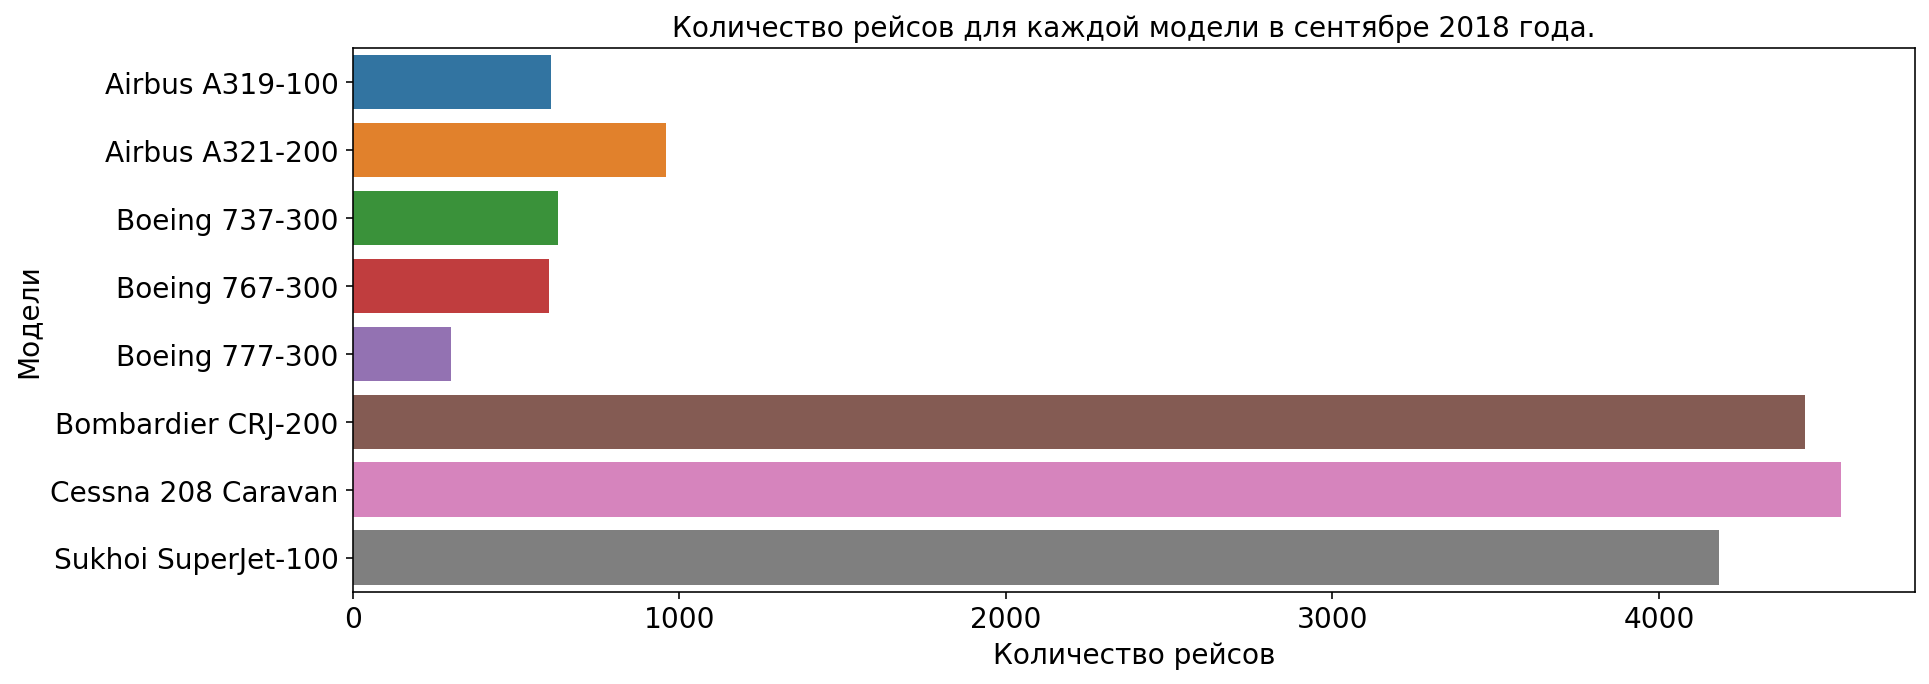

In [37]:
drawBarPlot(models,'flights_amount','model','Количество рейсов','Модели','Количество рейсов для каждой модели в сентябре 2018 года.')

Выделим модели: *Bombardier CRJ-200,Cessna 208 Caravan,Sukhoi SuperJet-100*. Данные модели сделали около 4000 рейсов каждый за сентябрь месяц. 

Информация по моделям самолётов:

### Airbus A319-100
Число пассажирских мест: 116 - 156 человек<br>
Страна производитель: Франция

### Airbus 321-200
Количество пассажирских мест: 185 мест<br>
Страна производитель: Франция

### Boeing 737-300
Количество пассажирских мест: 149  мест<br>
Страна производитель: США

### Boeing 767-300
Количество пассажирских мест: 328 мест<br>
Страна производитель: США

### Boeing 777-300
Количество пассажирских мест: 550 мест<br>
Страна производитель: США

### Bombardier CRJ-200
Количество пассажирских мест: 36 мест<br>
Страна производитель: Канада

### Cessna 208 Caravan
Количество пассажирских мест: 14 мест<br>
Страна производитель: США

### Sukhoi SuperJet-100
Количество пассажирских месте: 87 мест<br>
Страна производитель: Россия





In [38]:
seats = [156, 185, 149, 328, 550, 36, 14, 87]
countries_prod = ['France','France', 'USA', 'USA','USA', 'Canada', 'USA','Russia']

In [39]:
models['seats'] = pd.Series(seats)
models['countries_prod'] = pd.Series(countries_prod)

In [40]:
models

,model,flights_amount,company,seats,countries_prod
0,Airbus A319-100,607,Airbus,156,France
1,Airbus A321-200,960,Airbus,185,France
2,Boeing 737-300,630,Boeing,149,USA
3,Boeing 767-300,600,Boeing,328,USA
4,Boeing 777-300,300,Boeing,550,USA
5,Bombardier CRJ-200,4446,Bombardier,36,Canada
6,Cessna 208 Caravan,4557,Cessna,14,USA
7,Sukhoi SuperJet-100,4185,Sukhoi,87,Russia


In [41]:
company_grouped = models.groupby('company')['flights_amount'].sum()

In [42]:
company = pd.DataFrame({'company': company_grouped.keys(), 'flights_amount': company_grouped.values})

In [43]:
company

,company,flights_amount
0,Airbus,1567
1,Boeing,1530
2,Bombardier,4446
3,Cessna,4557
4,Sukhoi,4185


Выведем количество рейсов по компаниям производителям.

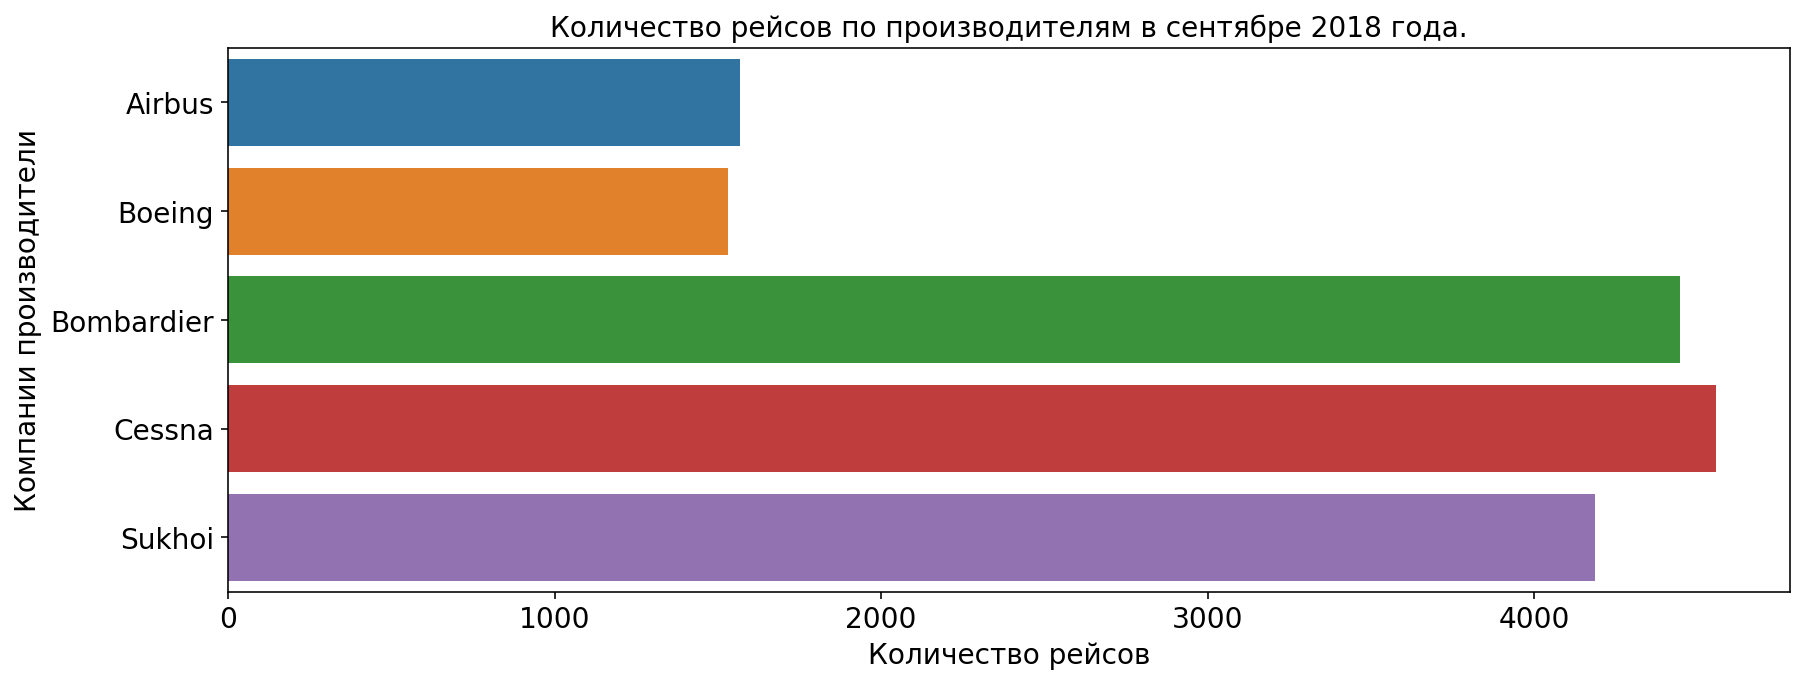

In [44]:
drawBarPlot(company,'flights_amount','company','Количество рейсов','Компании производители','Количество рейсов по производителям в сентябре 2018 года.')

Компании Airbus и Boeing выравнились на отметке *1500 рейсов*. Компании *Bombardier, Cessna, Sukhoi* имеют около 4000 рейсов каждый.

Посмотрим на отношение *flights_amount* и *seats*. Построим график рассеяния.

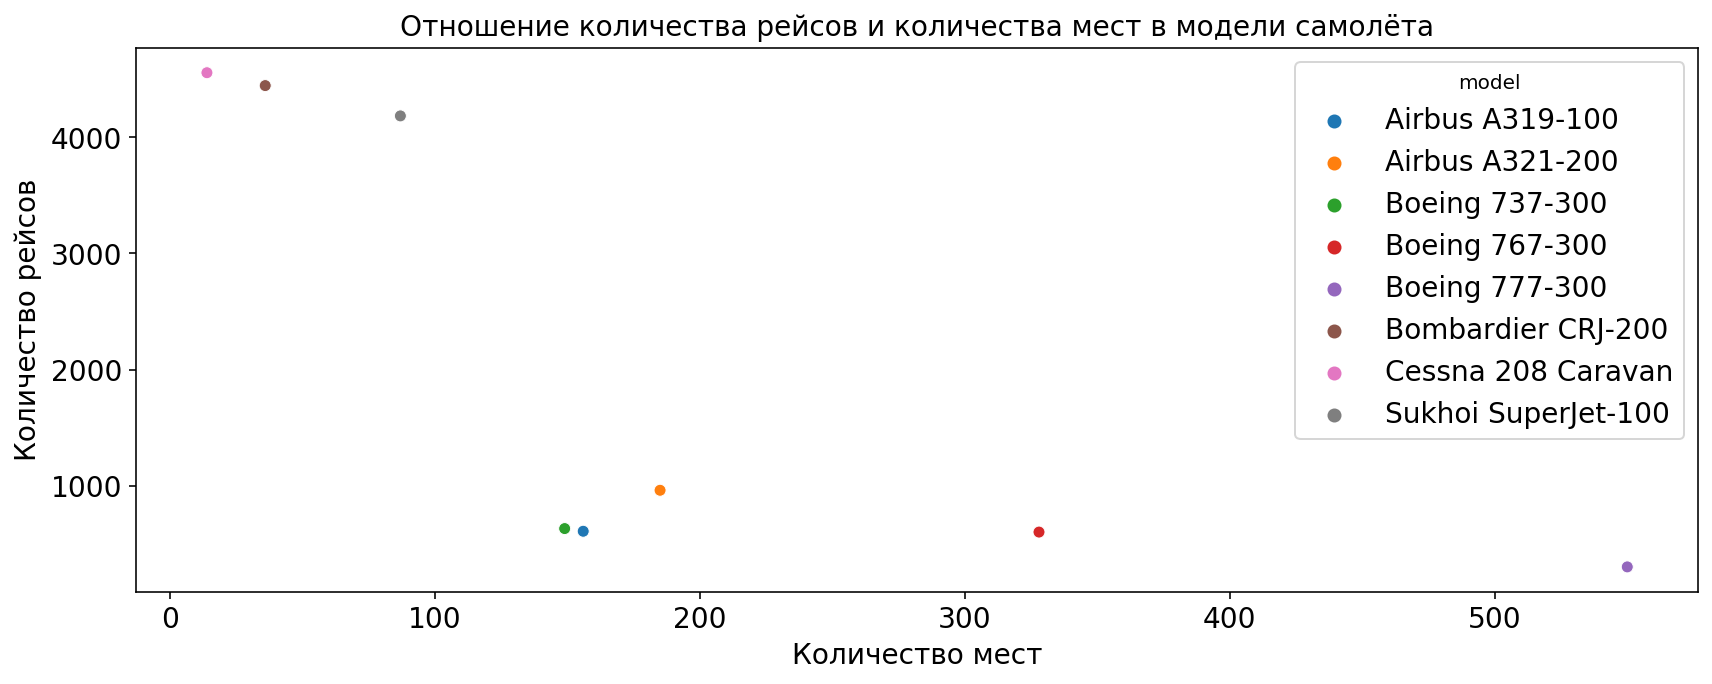

In [45]:
ax = sns.scatterplot(data=models, x='seats', y='flights_amount',hue='model')
plt.title('Отношение количества рейсов и количества мест в модели самолёта')
plt.xlabel('Количество мест')
plt.ylabel('Количество рейсов')
plt.show()

In [46]:
models

,model,flights_amount,company,seats,countries_prod
0,Airbus A319-100,607,Airbus,156,France
1,Airbus A321-200,960,Airbus,185,France
2,Boeing 737-300,630,Boeing,149,USA
3,Boeing 767-300,600,Boeing,328,USA
4,Boeing 777-300,300,Boeing,550,USA
5,Bombardier CRJ-200,4446,Bombardier,36,Canada
6,Cessna 208 Caravan,4557,Cessna,14,USA
7,Sukhoi SuperJet-100,4185,Sukhoi,87,Russia


Посмотрим на корреляцию

In [47]:
print(models['flights_amount'].corr(models['seats']))

-0.7219429981786245


Как видим есть отрицательная корреляция Пирсона между количеством рейсов и количеством мест в модели самолёта. Тем больше мест в самолёте, тем меньше рейсов. Следовательно, можем сделать вывод, что большие модели самолётов доволно реже вылетают, чем малые модели. 

Возьмём *Boeing 777-300*, у которого 550 мест, и *Cessna 208 Caravan*, у которого всего 14 мест.

In [48]:
small_big_models = models.query('model == "Boeing 777-300" or model == "Cessna 208 Caravan"')

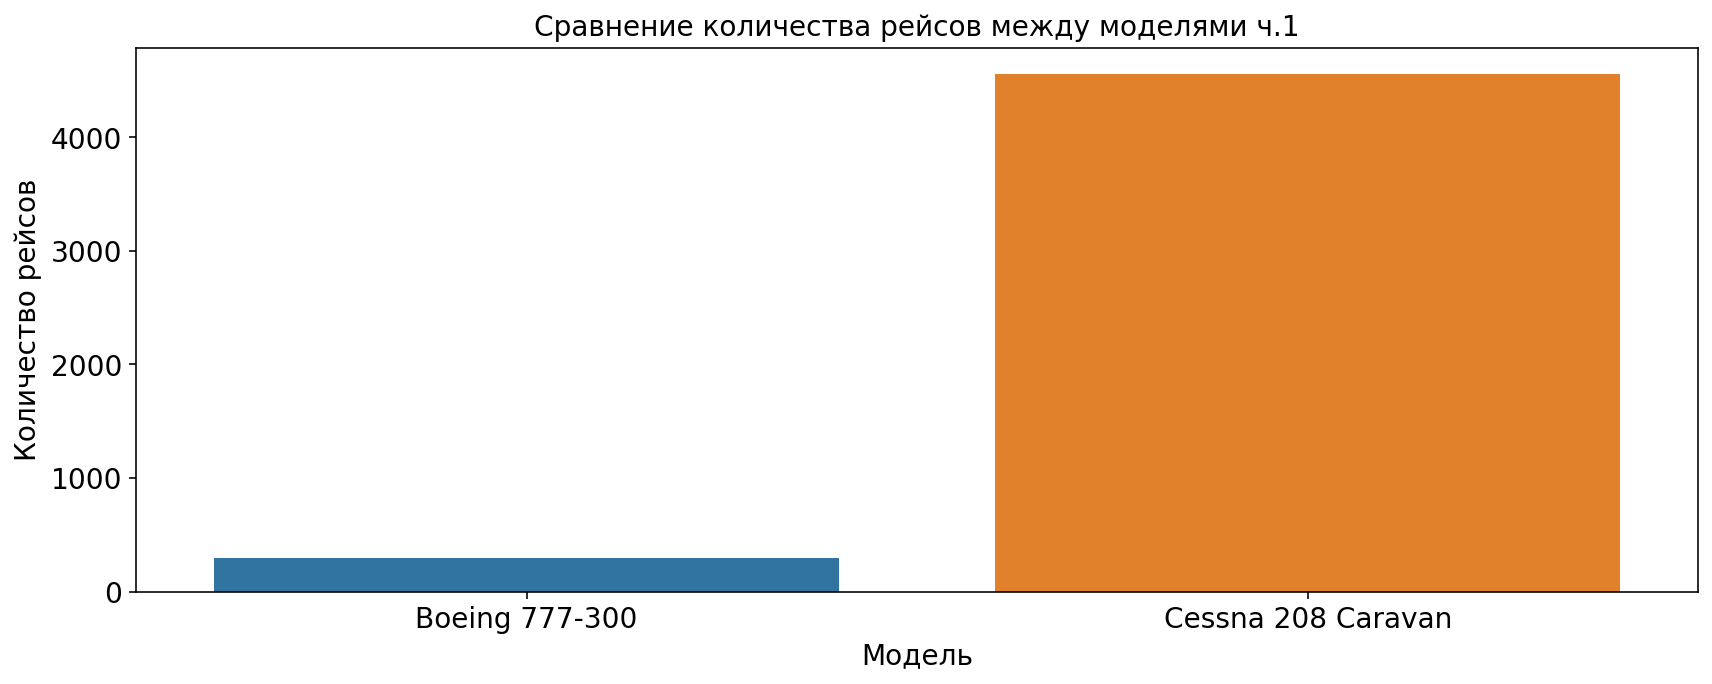

In [49]:
drawBarPlot(small_big_models,'model','flights_amount','Модель','Количество рейсов','Сравнение количества рейсов между моделями ч.1')

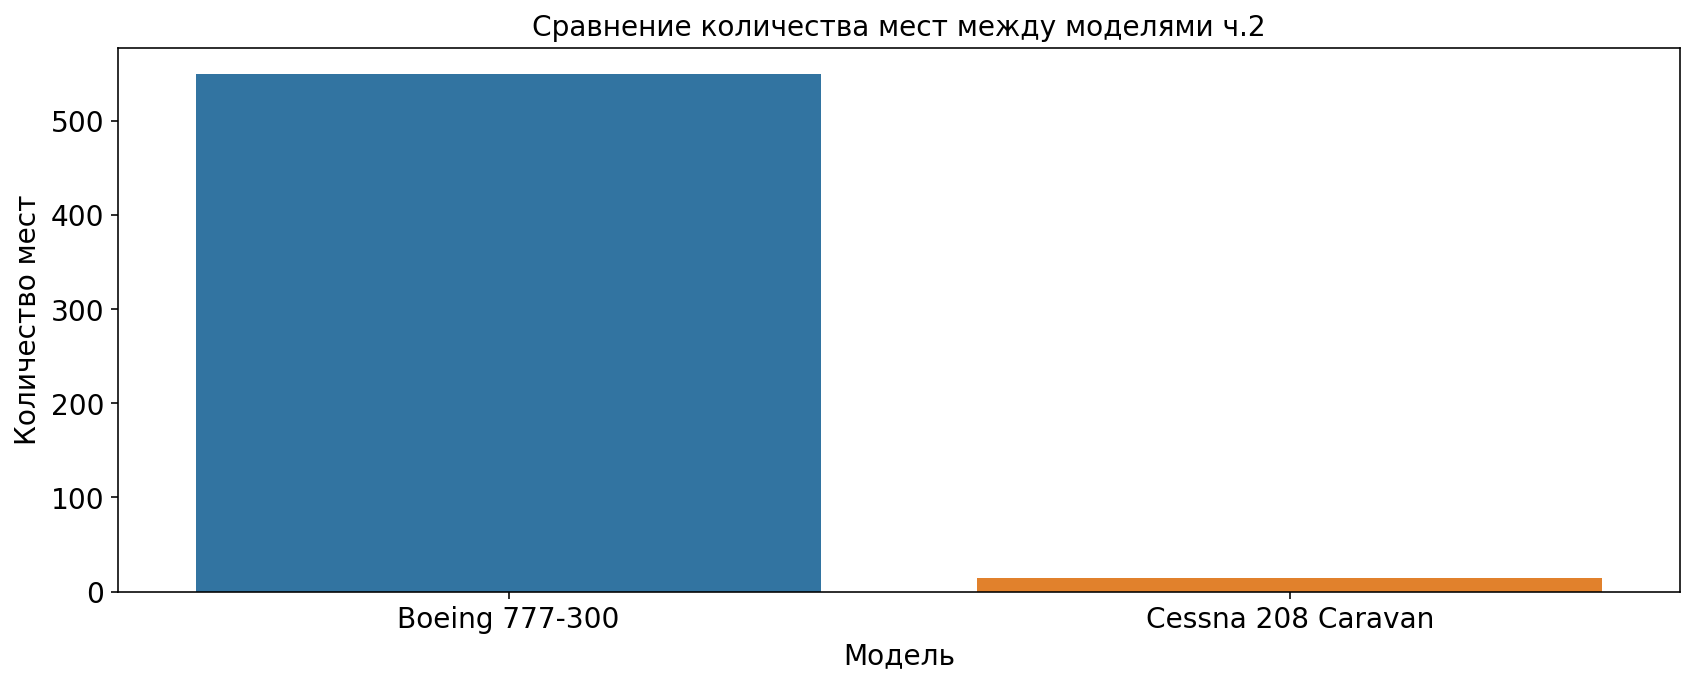

In [50]:
drawBarPlot(small_big_models,'model','seats','Модель','Количество мест','Сравнение количества мест между моделями ч.2')

Посмотрим на графики: на первом графике мы видим, что количество рейсов у модели *Cessna 208 Caravan* (14 мест) гораздо превышает, количество рейсов у модели *Boeing 777-300* (550 мест). <br>
На втором графике, видно, что модель *Boeing 777-300* гораздо больше чем модель *Cessna 208 Caravan*.

Можно предположить, что большие самолёты предназначены для дальних полётов. Следовательно, дальние полёты организуют реже. Поэтому мы видим малое количество рейсов. Что касается малых моделей, их намного часто используют. 

## Топ-5 моделей самолётов

In [51]:
models_sorted = models.sort_values(by='flights_amount',ascending=False)
models_sorted

,model,flights_amount,company,seats,countries_prod
6,Cessna 208 Caravan,4557,Cessna,14,USA
5,Bombardier CRJ-200,4446,Bombardier,36,Canada
7,Sukhoi SuperJet-100,4185,Sukhoi,87,Russia
1,Airbus A321-200,960,Airbus,185,France
2,Boeing 737-300,630,Boeing,149,USA
0,Airbus A319-100,607,Airbus,156,France
3,Boeing 767-300,600,Boeing,328,USA
4,Boeing 777-300,300,Boeing,550,USA


In [52]:
top_5_models = models_sorted.head()

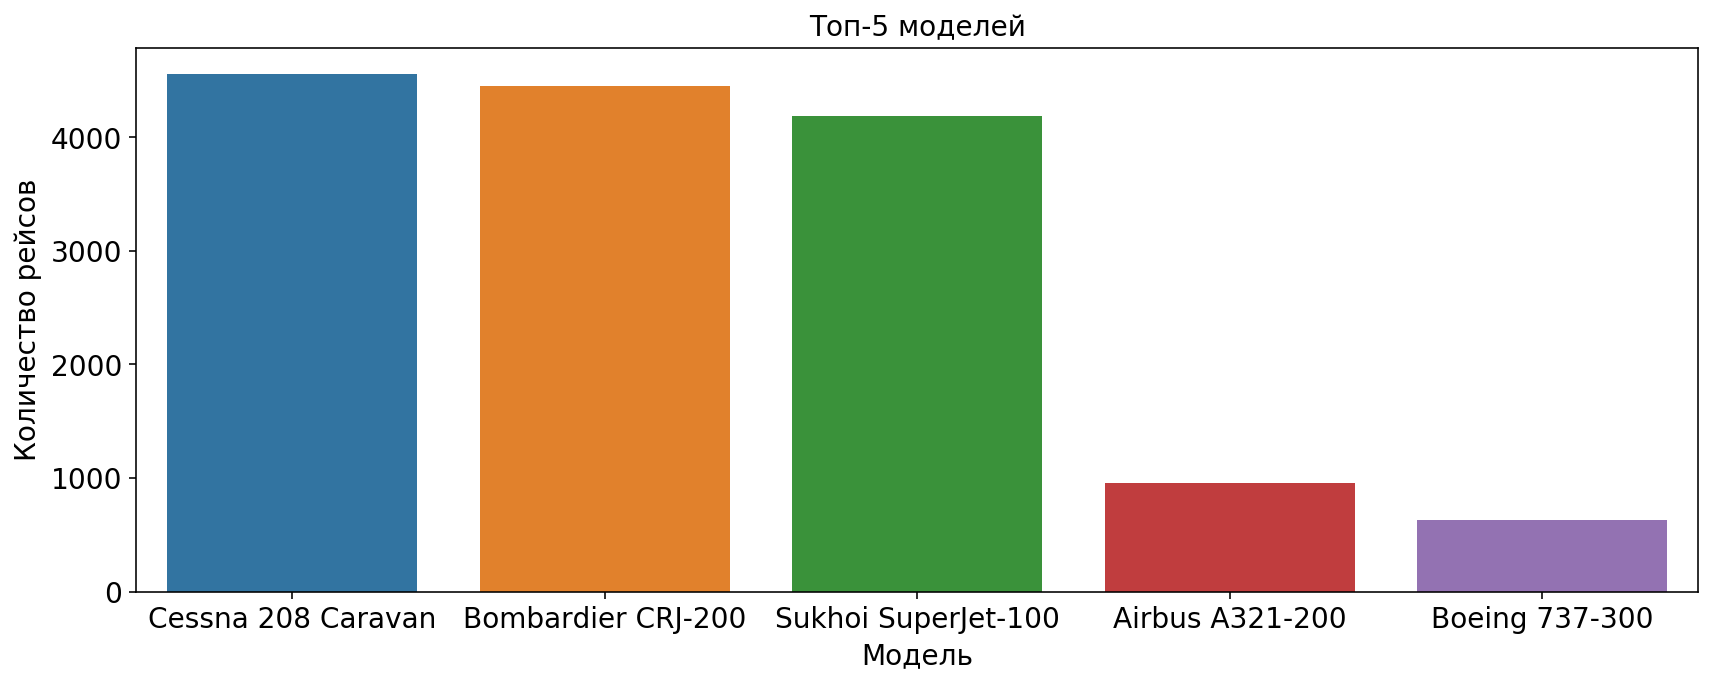

In [53]:
drawBarPlot(top_5_models,'model','flights_amount','Модель','Количество рейсов','Топ-5 моделей')

## ТОП-5 моделей
1. Cessna 208 Caravan
2. Bombardier CRJ-200
3. Sukhoi SuperJet-100
4. Airbus A321-200
5. Boeing 737-300

<br>

<a id="cityAnalysis"></a>
## Анализ городов

Проанализируем города. Воспользуемся динамической картой, чтобы посмотреть в каких городах были рейсы.

Создаем словарь

In [54]:
cities_dict = dict()

In [55]:
city.head()

,city,average_flights,federal_area,lat,lng,region
0,Абакан,3.871,Сибирский,53.722,91.444,Хакасия
1,Анадырь,1.000,Дальневосточный,64.731,177.502,Чукотский
2,Анапа,2.162,Южный,44.895,37.316,Краснодарский
3,Архангельск,5.355,Северо-Западный,64.539,40.517,Архангельская
4,Астрахань,2.451,Южный,46.366,48.056,Астраханская


Заполняем словарь

In [56]:
for i,city_info in enumerate(city.city.values):
    cities_dict[city_info] = {
        "city": city_info,
        "lng": city.loc[i,['lat']][0],
        "lat": city.loc[i,['lng']][0],
        "average_flights": city.loc[i,['average_flights']][0]
    }

In [57]:
# Создаем карту
m_3 = folium.Map(location=[62.146963, 82.737016], tiles='cartodbpositron', zoom_start=3)

# Добавляем маркеры на карту
mc = MarkerCluster()

tooltip = "Нажмите, чтобы увидеть среднее количество рейсов в день!"

In [58]:
for city_marker in cities_dict:
    popup = f'Average flights: {cities_dict[city_marker]["average_flights"]} in {cities_dict[city_marker]["city"]}'
    mc.add_child(Marker([cities_dict[city_marker]['lng'], cities_dict[city_marker]['lat']],popup=popup, tooltip=tooltip))
m_3.add_child(mc)    
# Display the map
m_3

## Федеральный округ

Сгруппируем города по федеральным округам, найдем общее среднее по каждому округу.

In [59]:
federal_area_grouped = city.groupby('federal_area')['average_flights'].mean()

In [60]:
federal_area_df = pd.DataFrame({'federal_area': federal_area_grouped.keys(), 'average_flights': federal_area_grouped.values})

In [61]:
federal_area_df

,federal_area,average_flights
0,Дальневосточный,2.502
1,Приволжский,4.766
2,Северо-Западный,5.562
3,Северо-Кавказский,2.473
4,Сибирский,3.941
5,Уральский,4.805
6,Центральный,15.062
7,Южный,5.113


Отсортируем

In [62]:
federal_area_df_sorted = federal_area_df.sort_values(by='average_flights',ascending=False)

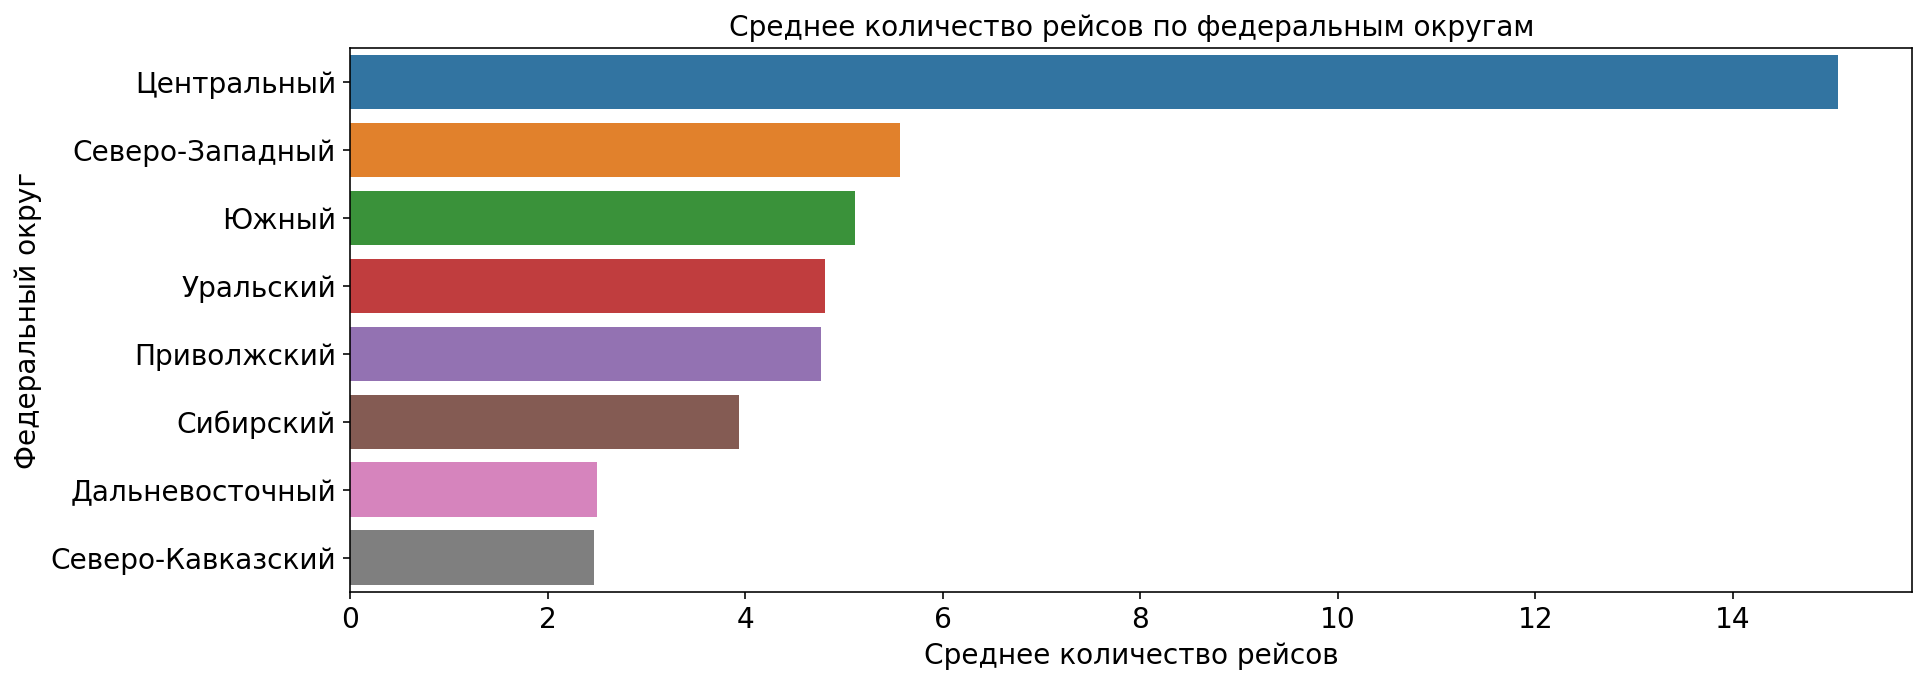

In [63]:
drawBarPlot(federal_area_df_sorted,'average_flights','federal_area','Среднее количество рейсов','Федеральный округ','Среднее количество рейсов по федеральным округам')

Центральный федеральный округ - самый популярный. Следом идут Северо-Западный и Южный федеральные округа.

## ТОП-5 Федеральных округов

In [64]:
top_5_federal_area = federal_area_df_sorted.head()

In [65]:
top_5_federal_area

,federal_area,average_flights
6,Центральный,15.062
2,Северо-Западный,5.562
7,Южный,5.113
5,Уральский,4.805
1,Приволжский,4.766


1. Центральный 
2. Северо-Западный
3. Южный
4. Уральский
5. Приволжский

Рассмотрим популярные города - выведем топ-10 городов по количеству рейсов.

In [66]:
cities_sorted = city.sort_values(by='average_flights',ascending=False)

In [67]:
top_10_cities = cities_sorted.head(10)
top_10_cities

,city,average_flights,federal_area,lat,lng,region
43,Москва,129.750,Центральный,55.754,37.620,Москва
70,Санкт-Петербург,31.156,Северо-Западный,59.939,30.316,Санкт-Петербург
54,Новосибирск,17.328,Сибирский,55.028,82.921,Новосибирская
33,Красноярск,11.578,Сибирский,56.009,92.852,Красноярский
20,Екатеринбург,11.320,Уральский,56.839,60.605,Свердловская
67,Ростов-на-Дону,10.195,Южный,47.222,39.719,Ростовская
63,Пермь,10.133,Приволжский,58.010,56.234,Пермский
10,Брянск,10.000,Центральный,53.242,34.365,Брянская
74,Сочи,9.609,Южный,43.586,39.723,Краснодарский
84,Ульяновск,9.578,Приволжский,54.308,48.375,Ульяновская


Выведем график

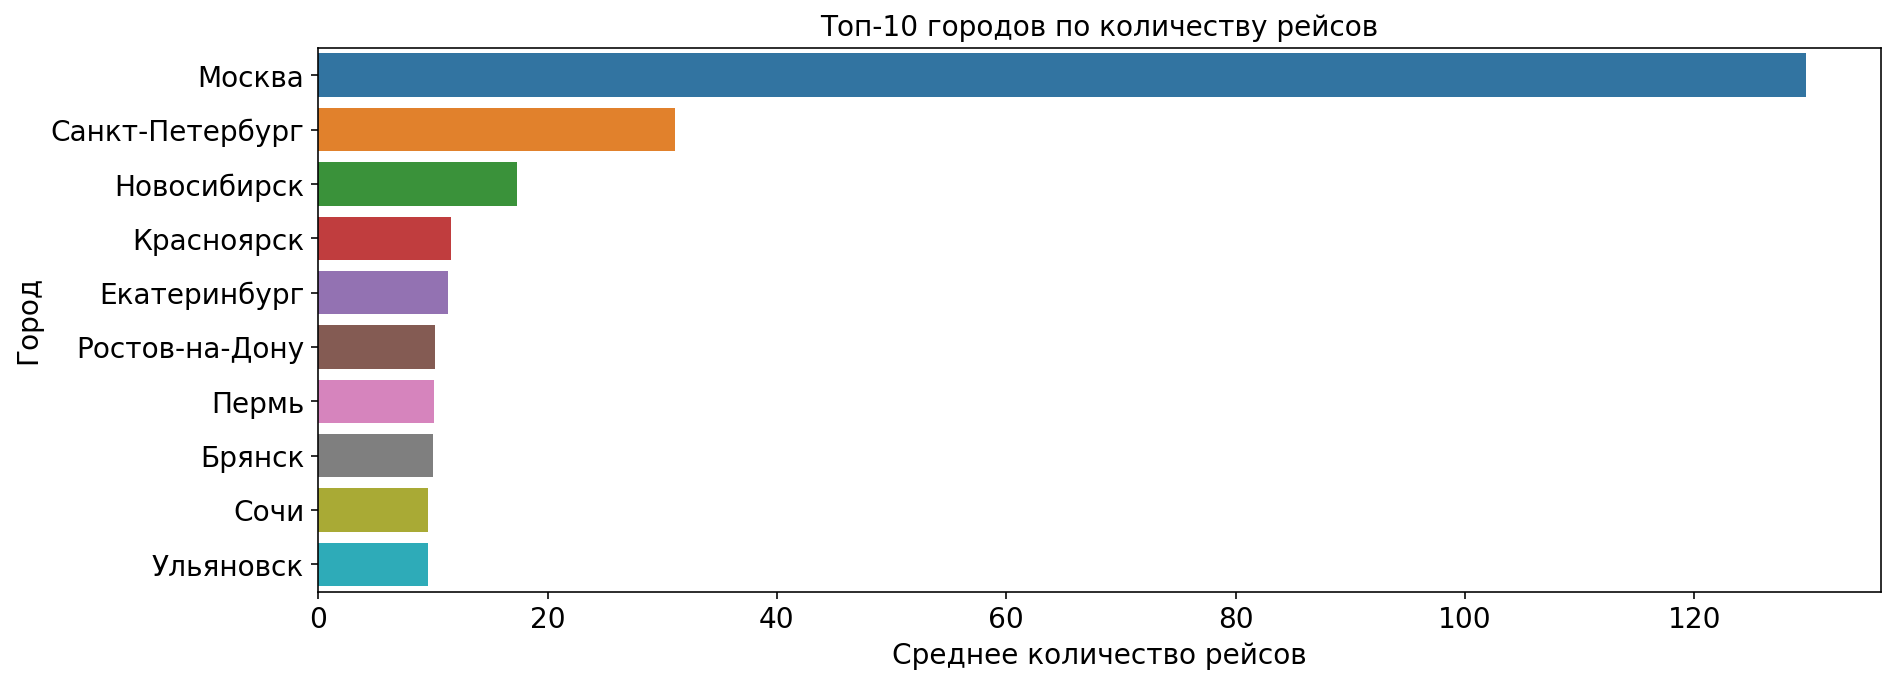

In [68]:
drawBarPlot(top_10_cities,'average_flights','city','Среднее количество рейсов','Город','Tоп-10 городов по количеству рейсов')

Большинство клиентов летают в Москву, потому что Москва - транзитный город и столица России. Между Москвой и Санкт-Петербургом могут быть ежедневные рейсы с определенной частотой в день (утром, днем, и вечером). Новосибирск - тоже транзитный город по Восточному региону. Могу предположить, что также может играть роль - количество аэропортов в городах.

## ТОП-10 городов
1. Москва
2. Санкт-Петербург
3. Новосибирск
4. Екатеринбург
5. Красноярск 
6. Пермь 
7. Ростов-на-Дону
8. Брянск
9. Ульяновск 
10. Советский 

<br>

<a id="results"></a>
# Этап 4 - Результаты работы

В ходе проекта, мы проанализировали данные авиакомпании и определили предпочтения пользователей:
1. Мы предобработали данные. Сделали Feature Engineering. 
2. Провели исследовательский анализ данных:
### Анализ моделей самолётов
- Выделили модели: Bombardier CRJ-200,Cessna 208 Caravan,Sukhoi SuperJet-100. Данные модели сделали около 4000 рейсов каждый за сентябрь месяц. 
- Компании Airbus и Boeing выравнились на отметке 1500 рейсов. Компании Bombardier, Cessna, Sukhoi имеют около 4000 рейсов каждый.
- Выявили что, есть отрицательная корреляция Пирсона между количеством рейсов и количеством мест в модели самолёта. Тем больше мест в самолёте, тем меньше рейсов. Следовательно, можем сделать вывод, что большие модели самолётов доволно реже вылетают, чем малые модели. 
- Предположили, что большие самолёты предназначены для дальних полётов. Следовательно, дальние полёты организуют реже. Поэтому мы видим малое количество рейсов. Что касается малых моделей, их намного часто используют. 

### ТОП-5 моделей
1. Cessna 208 Caravan
2. Bombardier CRJ-200
3. Sukhoi SuperJet-100
4. Airbus A321-200
5. Boeing 737-300

### Анализ городов
- Проанализировали федеральные округи. Центральный федеральный округ - самый популярный. Следом идут Северо-Западный и Южный федеральные округа.
- Проанализировали города. Большинство клиентов летают в Москву, потому что Москва - транзитный город и столица России. Между Москвой и Санкт-Петербургом могут быть ежедневные рейсы с определенной частотой в день (утром, днем, и вечером). Новосибирск - тоже транзитный город по Восточному региону. Могу предположить, что также может играть роль - количество аэропортов в городах.

### ТОП-5 Федеральных округов
1. Центральный 
2. Северо-Западный
3. Южный
4. Уральский
5. Приволжский

### ТОП-10 городов
1. Москва
2. Санкт-Петербург
3. Новосибирск
4. Екатеринбург
5. Красноярск 
6. Пермь 
7. Ростов-на-Дону
8. Брянск
9. Ульяновск 
10. Советский 

Исходя из полученного результата, можно определить предпочтении пользователей